In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat') # only noise    
analysisData = scio.loadmat('../generate_ligo/data.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 1024

# Search range of phase coefficients
"""
        r = r * 1e8 * pc
        m1,m2 = m1,m2 *m_sun
        DL,DLS = DL,DLS * 1e6 * pc
        v = v * 1e6
        r   m1  m2   tc   phi_c   DL  DLS   zl  v  omega  y
"""
rmin = [0.8, 4 , 4 ,-1 , -2*np.pi,10,  10  ,0, 0.8,0   ,-1]
rmax = [1.2, 35, 35, 1 , 2*np.pi,1000, 1000,2, 1.2,1000, 1]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)
t = np.linspace(-10,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


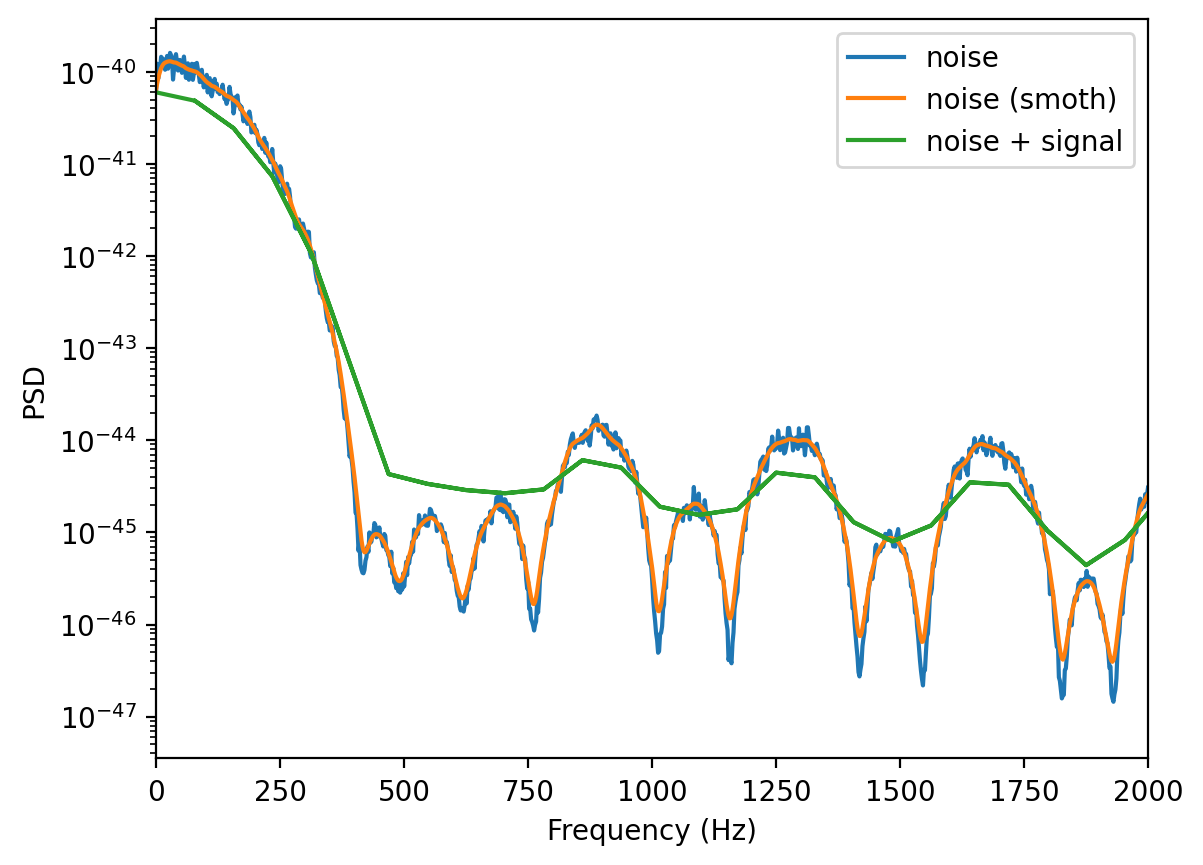

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 4

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'dataXSq': t**2,
    # 'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 20}, nRuns)

开始土法找参数问题！！！！！！！！


  0%|          | 0/20 [00:00<?, ?it/s]

f_geo:(2.416972594278723+0.34886698216312095j)
f_geo:(2.4071136988393294+0.272600561524857j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(2.2889428304106376+0.16720589864735946j)
f_geo:(1.6988335057425616+0.20679950229092472j)
f_geo:(1.8536243601413989-1.1028149979042217j)


/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:457: RuntimeWarning: invalid value encountered in divide
  innProd = np.sum((1/dataLen) * (fftX / psdVec4Norm)*fftY.conj())
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:354: RuntimeWarning: invalid value encountered in power
  sigVec = G * M_c / (c ** 2 * r) * theta_t ** (-1/4) *np.cos(2 * phi_c - 2 * theta_t ** (5/8)) #* F_geo
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:351: RuntimeWarning: invalid value encountered in sqrt
  F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)


f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.2678306332077938+1.5509546345537994j)
f_geo:(1.327100418737541+0.20102401652015223j)
f_geo:(nan+nanj)
f_geo:(5.123184293292368+3.3881150353534135j)
f_geo:(nan+nanj)
f_geo:(0.35782018570926155-0.7828623897710936j)
f_geo:(0.955941476876933+0.3396779028698161j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.3303579222134494+0.8654724274849595j)
f_geo:(1.095025044542917-0.15050082911689108j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.2132151060287288+0.5260609855694811j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(6.435186603322891+1.3911021131677723j)
f_geo:(0.5270338301120459-0.03564031968821083j)
f_geo:(2.3327285641832898-0.14596406794660444j)


  5%|▌         | 1/20 [00:00<00:13,  1.37it/s]

f_geo:(1.520034719463694-0.2894905959994006j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.1527853808916562-0.710689000607941j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.3563598865054491-0.8004722295401668j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.4155314174799645+0.12937203721816182j)


 10%|█         | 2/20 [00:00<00:07,  2.42it/s]

f_geo:(nan+nanj)
f_geo:(8.827377996524502-5.051329214660806j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.4760616617238005-0.21872178316824398j)
f_geo:(0.3748860015086599+0.4420898561275765j)
f_geo:(nan+nanj)


 45%|████▌     | 9/20 [00:01<00:00, 11.16it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.7968348178292057-1.8918764610777845j)
f_geo:(nan+nanj)
f_geo:(4.886620301805036+4.522192062566699j)
f_geo:(3.2871958315231384+0.6224785549967199j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 85%|████████▌ | 17/20 [00:01<00:00, 21.32it/s]

f_geo:(nan+nanj)
f_geo:(1.8763005373261836+1.5671346425010222j)
f_geo:(2.4361262368213077-1.0988773540104082j)
f_geo:(nan+nanj)
f_geo:(3.817018284171019-0.7429810755130656j)
f_geo:(0.4584848352880271+0.6366163277103333j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.7598748152661245-0.06471048087742327j)


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.6820509527070795-0.5118333103150612j)
f_geo:(2.740292482432597+2.269806602879268j)


  0%|          | 0/20 [00:00<?, ?it/s]

f_geo:(nan+nanj)
f_geo:(1.6960100741770838-0.034618610480530936j)
f_geo:(1.1611967880058018+0.10318221881179687j)
f_geo:(1.5909340652145765-0.8513101217231173j)
f_geo:(nan+nanj)
f_geo:(6.142342473475311+2.7815872184607047j)
f_geo:(1.6374687344110406+0.377490571343247j)
f_geo:(1.216308387902102-0.15900863746604602j)
f_geo:(nan+nanj)
f_geo:(1.351128132138697-0.03405529888492627j)
f_geo:(nan+nanj)
f_geo:(1.6481914081739575+0.1418130218528449j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(2.715799624673378-0.3027987452622842j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.6430588523103022-0.3803807296290086j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.2429173956821753-0.450121088196898j)
f_geo:(nan+nanj)
f_geo:(1.743281139111318-1.2274129126445312j)
f_geo:(1.298165155251245-0.1922041405191244j)
f_geo:(2.1759751866445485-0.13989887415649618j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.740767859273612+0.7094505706998251j)
f_geo:(0.9344061301715904+0.012329323895689

  5%|▌         | 1/20 [00:00<00:14,  1.36it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(2.6970142712718155+1.0229146876515949j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 10%|█         | 2/20 [00:00<00:07,  2.41it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 25%|██▌       | 5/20 [00:01<00:02,  6.31it/s]

f_geo:(nan+nanj)
f_geo:(1.8142105391822096-0.9099451095583917j)
f_geo:(nan+nanj)
f_geo:(5.2667347020390505+2.534063476954829j)


 45%|████▌     | 9/20 [00:01<00:00, 12.17it/s]

f_geo:(0.9483591187568351+0.18204008591726023j)
f_geo:(1.5075056457902583+0.7083992190626297j)
f_geo:(nan+nanj)
f_geo:(0.6726747035112748+2.5039670001989616j)
f_geo:(nan+nanj)
f_geo:(3.6665134153928616-1.2418503595653172j)
f_geo:(nan+nanj)
f_geo:(1.5247044494654796+0.4710374184449409j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 75%|███████▌  | 15/20 [00:01<00:00, 16.47it/s]

f_geo:(nan+nanj)
f_geo:(0.8572053788790341+0.15189852670702225j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


100%|██████████| 20/20 [00:01<00:00, 12.11it/s]


f_geo:(2.7999264446225975-0.9668056389053826j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.206894038097299+1.1672907626094453j)
f_geo:(nan+nanj)


  0%|          | 0/20 [00:00<?, ?it/s]

f_geo:(3.194780177985509-1.5040358602503132j)
f_geo:(nan+nanj)
f_geo:(0.8654758189520633-0.9734945956230218j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(8.52711148265579+2.206915855997133j)
f_geo:(nan+nanj)
f_geo:(1.6543935994786707-2.4780796291146756j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.9431114221959414+3.02021060022011j)
f_geo:(nan+nanj)
f_geo:(0.9806648538052611-0.21326427483579072j)
f_geo:(0.720382591564896-1.0833981732241063j)
f_geo:(1.2823427511193635+1.510363795922503j)
f_geo:(3.0256919020560504-0.10121661630469857j)
f_geo:(nan+nanj)
f_geo:(4.698172316743559-1.641453348853468j)
f_geo:(1.445885569124735+0.667459699184942j)
f_geo:(2.3881706140568624-0.23510470713561754j)
f_geo:(1.1936188340981602+0.971030239885324j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.5181957720575778-0.42644316366639295j)
f_geo:(3.4964694532036766+0.8290271783320692j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.7110690004091882+0.43303738418768334j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f

  5%|▌         | 1/20 [00:00<00:13,  1.36it/s]

f_geo:(1.91606716400862+0.19902494010159247j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 10%|█         | 2/20 [00:00<00:06,  2.65it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.8301618116486857+0.6955620702968257j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 25%|██▌       | 5/20 [00:00<00:02,  7.35it/s]

f_geo:(nan+nanj)
f_geo:(1.6318002722667904+0.8740369198381504j)
f_geo:(nan+nanj)
f_geo:(28.02031373110645-6.8304354200865385j)
f_geo:(nan+nanj)
f_geo:(2.34107055744387-1.4531898224790567j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(5.136718580174289+1.9521833696915187j)
f_geo:(nan+nanj)


 35%|███▌      | 7/20 [00:01<00:01,  8.43it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.0833548278593788-0.929380786092511j)


 60%|██████    | 12/20 [00:01<00:00, 16.55it/s]

f_geo:(nan+nanj)
f_geo:(0.6528559414116766-0.4716950688358694j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(0.3067988075903836-0.7098954754613194j)


 85%|████████▌ | 17/20 [00:01<00:00, 22.92it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.1624827946235254+0.7927444861816575j)
f_geo:(2.561380894959939-1.143867501123665j)
f_geo:(2.548659829325955+1.1473616601897698j)


  0%|          | 0/20 [00:00<?, ?it/s]

f_geo:(nan+nanj)
f_geo:(0.7063433235771674-0.4210696223640054j)
f_geo:(1.7542257073028582-0.41841899231530094j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.3218581139829102-2.191729119033126j)
f_geo:(1.4651589783655499+0.8381204969783878j)
f_geo:(nan+nanj)
f_geo:(1.5209698786516248-0.2861077570452909j)
f_geo:(0.7177326831698536+0.040347953798156165j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.401431357894943+1.3663197303071188j)
f_geo:(nan+nanj)
f_geo:(4.369293512589279+0.7668989058524093j)
f_geo:(4.205975405548895-0.05101665084692846j)
f_geo:(1.1872255018832232-0.8863144604006548j)
f_geo:(nan+nanj)
f_geo:(1.1280163011166053-0.9178663919300418j)
f_geo:(nan+nanj)
f_geo:(4.2538074788426945+0.11240204976247907j)
f_geo:(1.8511655902370083+0.5067326709598585j)
f_geo:(3.8829029862094426+5.1673599997513415j)
f_geo:(2.081995918829792+0.836735658353384j)
f_geo:(6.12864721680762-0.888105337831312

  5%|▌         | 1/20 [00:00<00:13,  1.36it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(1.3495579650815794+0.20184858508635084j)
f_geo:(nan+nanj)


 10%|█         | 2/20 [00:00<00:06,  2.73it/s]

f_geo:(nan+nanj)
f_geo:(1.1384435667451487-2.3006580771307124j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 30%|███       | 6/20 [00:00<00:01,  9.34it/s]

f_geo:(4.033001556586047-1.833138306155716j)
f_geo:(0.657232699313486-0.012046250176054285j)
f_geo:(2.206398162305855-0.10538646213182692j)
f_geo:(nan+nanj)
f_geo:(0.9704559613696272+0.406688226262898j)
f_geo:(nan+nanj)
f_geo:(0.9431655095581819+2.2275872672743557j)
f_geo:(3.855156655930693+4.845130691299248j)
f_geo:(2.339729217402009-0.894532636163196j)
f_geo:(nan+nanj)


 45%|████▌     | 9/20 [00:01<00:00, 12.92it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(2.0444843269965416+0.4410827860111711j)
f_geo:(nan+nanj)
f_geo:(1.7307827631587007+1.1741032256887247j)
f_geo:(1.7490866790156498+0.6557281378934968j)
f_geo:(3.7335471702877756+4.161158607418035j)
f_geo:(0.9508670857962992-0.3465701393489839j)
f_geo:(nan+nanj)
f_geo:(1.7441729365724234+0.3293444768068064j)


 60%|██████    | 12/20 [00:01<00:00, 12.29it/s]

f_geo:(nan+nanj)
f_geo:(1.281906396233692-0.6200428801424893j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 75%|███████▌  | 15/20 [00:01<00:00, 14.93it/s]

f_geo:(nan+nanj)
f_geo:(1.2519996981064958-1.4554709301460957j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.796270047700757-1.855975379581372j)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


 95%|█████████▌| 19/20 [00:01<00:00, 17.08it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(3.8120902806971264+2.035415108234333j)
f_geo:(nan+nanj)
f_geo:(1.0954570185392494-0.570691711408245j)
f_geo:(nan+nanj)


100%|██████████| 20/20 [00:01<00:00, 11.62it/s]

f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)
f_geo:(nan+nanj)


/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


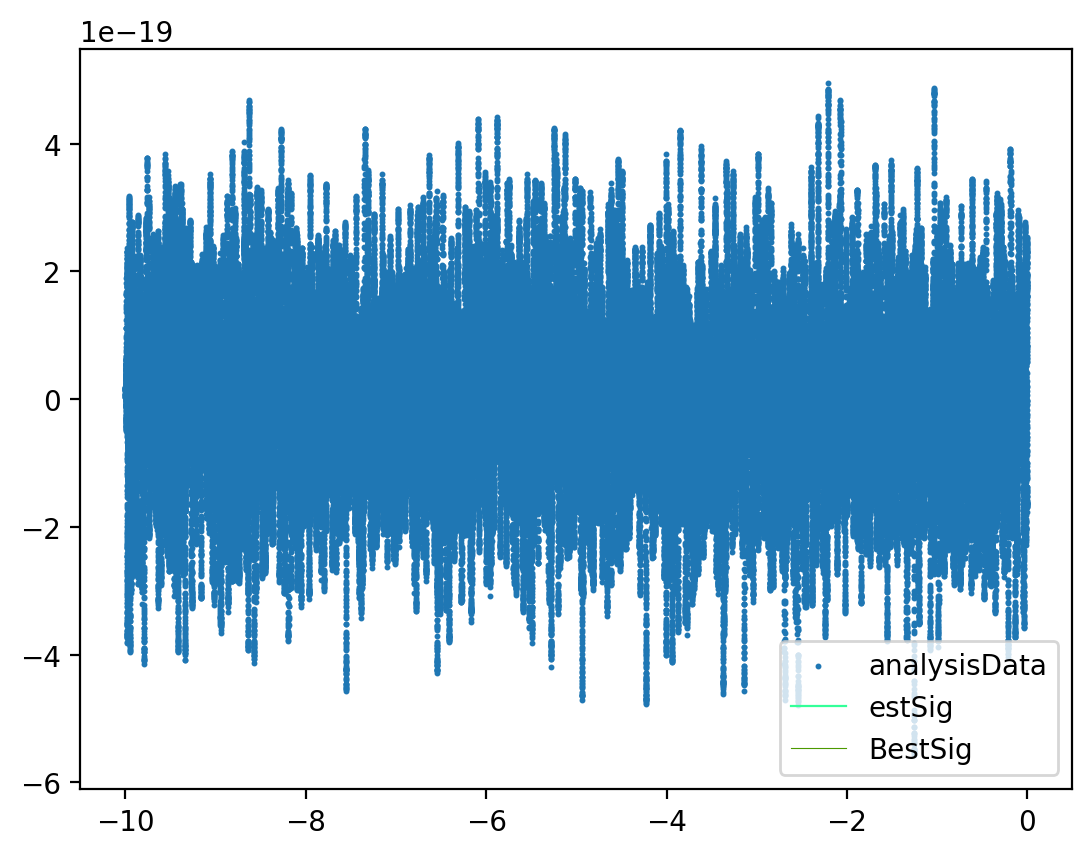

[nan nan nan ... nan nan nan]


In [6]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color=[76/255,153/255,0/255],lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
print(outResults['allRunsOutput'][lpruns]['estSig'])

In [7]:
# Print estimated parameters
print('Estimated parameters:')
print('r = {:.4e}'.format(outResults['r']))
print('m1 = {:.4e}'.format(outResults['m1'])) 
print('m2 = {:.4e}'.format(outResults['m2']))
print('tc = {:.4f}'.format(outResults['tc']))
print('phi_c = {:.4f}'.format(outResults['phi_c']))
print('DL = {:.4e}'.format(outResults['DL']))
print('DLS = {:.4e}'.format(outResults['DLS']))
print('zl = {:.4f}'.format(outResults['zl']))
print('v = {:.4e}'.format(outResults['v']))
print('omega = {:.4f}'.format(outResults['omega']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.2f}'.format(outStruct[lpruns]['bestFitness']))
    print('r = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['r']))
    print('m1 = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m1']))
    print('m2 = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m2']))
    print('tc = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['tc']))
    print('phi_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['phi_c']))
    print('DL = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['DL']))
    print('DLS = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['DLS']))
    print('zl = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['zl']))
    print('v = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['v']))
    print('omega = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['omega']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters:
r = 2.0000e+00
m1 = 2.0000e+00
m2 = 2.0000e+00
tc = 2.0000
phi_c = 2.0000
DL = 2.0000e+00
DLS = 2.0000e+00
zl = 2.0000
v = 2.0000e+00
omega = 2.0000
y = 2.0000

Run No.1:
bestFitness=inf
r = 2.0000e+00
m1 = 2.0000e+00
m2 = 2.0000e+00
tc = 2.0000
phi_c = 2.0000
DL = 2.0000e+00
DLS = 2.0000e+00
zl = 2.0000
v = 2.0000e+00
omega = 2.0000
y = 2.0000

Run No.2:
bestFitness=inf
r = 2.0000e+00
m1 = 2.0000e+00
m2 = 2.0000e+00
tc = 2.0000
phi_c = 2.0000
DL = 2.0000e+00
DLS = 2.0000e+00
zl = 2.0000
v = 2.0000e+00
omega = 2.0000
y = 2.0000

Run No.3:
bestFitness=inf
r = 2.0000e+00
m1 = 2.0000e+00
m2 = 2.0000e+00
tc = 2.0000
phi_c = 2.0000
DL = 2.0000e+00
DLS = 2.0000e+00
zl = 2.0000
v = 2.0000e+00
omega = 2.0000
y = 2.0000

Run No.4:
bestFitness=inf
r = 2.0000e+00
m1 = 2.0000e+00
m2 = 2.0000e+00
tc = 2.0000
phi_c = 2.0000
DL = 2.0000e+00
DLS = 2.0000e+00
zl = 2.0000
v = 2.0000e+00
omega = 2.0000
y = 2.0000
